In [64]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [65]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [66]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [67]:
from sqlalchemy import func
from datetime import timedelta

In [68]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///SurfsUp/Resources/hawaii.sqlite")

In [69]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [70]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [71]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [72]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [73]:
# explore measurment
first_measurement = session.query(measurement).first()
first_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1eb19dd4950>,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'id': 1}

In [74]:
# explore measurment
first_station = session.query(station).first()
first_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1eb19dd47d0>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168}

In [75]:
# Find the most recent date in the data set.

for row in session.query(measurement.date).order_by(measurement.date.desc()).limit(1) :   
    print(row)


('2017-08-23',)


In [76]:
# convert measurement to DF

measurement_data = session.query(measurement).all()
measurement_df = pd.DataFrame([(m.id, m.station, m.date, m.prcp, m.tobs) for m in measurement_data],
                               columns=['id', 'station', 'date', 'prcp', 'tobs'])
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [ ]:
# convert columns to right dtype

measurement_df = measurement_df.astype({'date' : 'datetime64[ns]'})
measurement_df.dtypes

id                  int64
station            object
date       datetime64[ns]
prcp              float64
tobs              float64
dtype: object

In [170]:
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

# calculate date 1Y before

date_max = max(measurement_df['date'])
date_1Y = date_max - pd.DateOffset(years=1)

print(f'most recent date is {date_max}')
print(f'1Y frm the last date {date_1Y}')


most recent date is 2017-08-23 00:00:00
1Y frm the last date 2016-08-23 00:00:00


In [150]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Save the query results as a Pandas DataFrame. Explicitly set the column names

data_1y = measurement_df['date']>=date_1Y
data_1y = measurement_df[data_1y]

data_1y

,id,station,date,prcp,tobs
2363,2364,USC00519397,2016-08-23,0.00,81.0
2364,2365,USC00519397,2016-08-24,0.08,79.0
2365,2366,USC00519397,2016-08-25,0.08,80.0
2366,2367,USC00519397,2016-08-26,0.00,79.0
2367,2368,USC00519397,2016-08-27,0.00,77.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


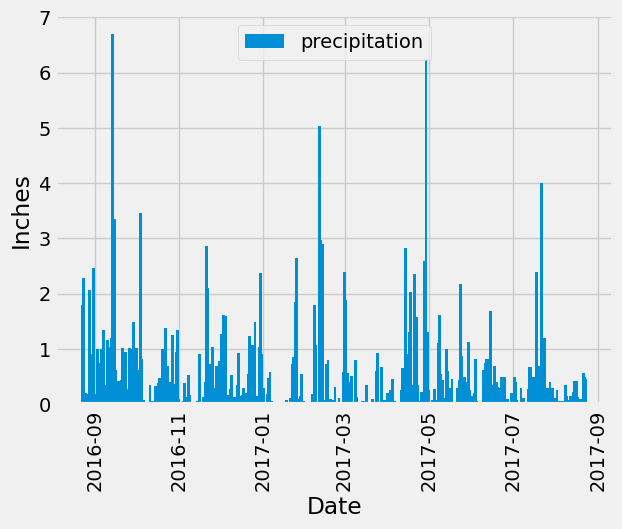

In [151]:
# Use Pandas Plotting with Matplotlib to plot the data
# chart = precipitations_1y.groupby(['date'])['prcp'].mean()
plt.bar(data_1y['date'],data_1y['prcp'],\
         label='precipitation', width=2)


plt.xlabel('Date')
plt.xticks(rotation = 90)
plt.ylabel('Inches')
plt.legend(loc='upper center')



plt.show()


In [152]:
# Use Pandas to calculate the summary statistics for the precipitation data

summary = data_1y['prcp'].describe()
summary_df = summary.reset_index()

summary_df = summary_df.rename(columns={'index' : 'stats','prcp':'precipitation'})
summary_df = summary_df.set_index('stats')
summary_df


,precipitation
stats,
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [156]:
# Design a query to calculate the total number of stations in the dataset
station_number = session.query(measurement.station).distinct().count()

print(station_number)


9


In [ ]:
### pandas ????

stations_len = len(measurement_df['station'].unique())

stations_len

9

In [ ]:
### pandas ????

# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_active = measurement_df['station'].value_counts()
station_active


station
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: count, dtype: int64

In [157]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_active = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc())\
    .all()
station_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [158]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = station_active[0][0]
most_active_station

'USC00519281'

In [159]:
most_active_station_stats = session.query(func.min(measurement.tobs),\
    func.max(measurement.tobs),\
    func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station).\
    all()
most_active_station_stats

[(54.0, 85.0, 71.66378066378067)]

In [169]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

data_1y_station1 = data_1y[data_1y['station']== most_active_station]
data_1y_station1 = data_1y_station1['tobs']
data_1y_station1


14607    77.0
14608    77.0
14609    80.0
14610    80.0
14611    75.0
         ... 
14954    77.0
14955    77.0
14956    76.0
14957    76.0
14958    79.0
Name: tobs, Length: 352, dtype: float64

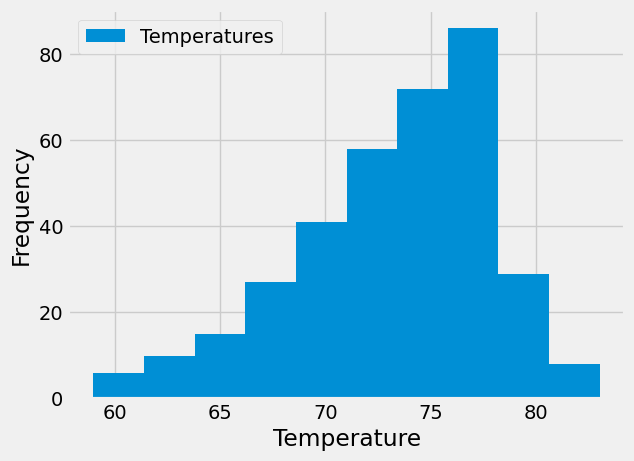

In [168]:
plt.hist(data_1y_station1, label='Temperatures')

plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc = 'upper left')

# Close Session

In [16]:
# Close Session
session.close()